In [0]:
import numpy as np
from matplotlib import pyplot as plt

In [0]:
def sin(x, T=100):
    return np.sin(2.0*np.pi*x/T)

In [0]:
def toy_problem(T=100,ampl=0.05):
    x=np.arange(0,2*T+1)
    noise=ampl*np.random.uniform(low=-1,high=1,size=len(x))
    return sin(x)+noise

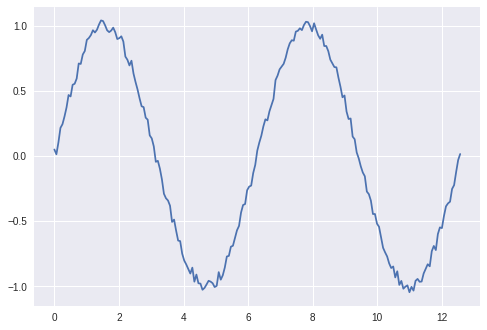

In [0]:
f=toy_problem(T=100,ampl=0.05)
x=np.arange(0,200+1)*(np.pi*4)/200
plt.plot(x,f)

In [0]:
length_of_sequence=2*100
maxlen=25

data=[]
target=[]
for i in range(0,length_of_sequence-maxlen+1):
    data.append(f[i:(i+maxlen)])   # 0-24, 1-25, 2-26, ..., 175-199
    target.append(f[i+maxlen])     # 25, 26, 27, ..., 200

In [0]:
X=np.array(data).reshape(len(data),maxlen,1)
y=np.array(target).reshape(len(data),1)

In [0]:
X.shape, y.shape

((176, 25, 1), (176, 1))

## Keras

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [0]:
model = Sequential()
model.add(LSTM(32, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(y.shape[1], activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, y, epochs=30, batch_size=10, verbose=2, validation_split=0.3)

Train on 123 samples, validate on 53 samples
Epoch 1/30
 - 2s - loss: 0.3204 - val_loss: 0.2106
Epoch 2/30
 - 1s - loss: 0.1080 - val_loss: 0.1004
Epoch 3/30
 - 1s - loss: 0.0643 - val_loss: 0.0618
Epoch 4/30
 - 1s - loss: 0.0456 - val_loss: 0.0419
Epoch 5/30
 - 1s - loss: 0.0334 - val_loss: 0.0321
Epoch 6/30
 - 1s - loss: 0.0237 - val_loss: 0.0219
Epoch 7/30
 - 1s - loss: 0.0143 - val_loss: 0.0108
Epoch 8/30
 - 1s - loss: 0.0065 - val_loss: 0.0045
Epoch 9/30
 - 1s - loss: 0.0023 - val_loss: 0.0028
Epoch 10/30
 - 1s - loss: 0.0019 - val_loss: 0.0026
Epoch 11/30
 - 1s - loss: 0.0016 - val_loss: 0.0018
Epoch 12/30
 - 1s - loss: 0.0015 - val_loss: 0.0018
Epoch 13/30
 - 1s - loss: 0.0016 - val_loss: 0.0018
Epoch 14/30
 - 1s - loss: 0.0015 - val_loss: 0.0017
Epoch 15/30
 - 1s - loss: 0.0015 - val_loss: 0.0018
Epoch 16/30
 - 1s - loss: 0.0014 - val_loss: 0.0016
Epoch 17/30
 - 1s - loss: 0.0014 - val_loss: 0.0016
Epoch 18/30
 - 1s - loss: 0.0013 - val_loss: 0.0015
Epoch 19/30
 - 1s - loss: 0.

In [0]:
y_hat = model.predict(X)

In [0]:
X.shape, X[:,0,:].shape

((176, 25, 1), (176, 1))

In [0]:
Z=X[:1]                                        # 1-25
original = [f[i] for i in range(maxlen)]       # 1-25
predicted = [None for i in range(maxlen)]      # 25개짜리 빈 list

for i in range(length_of_sequence - maxlen + 1):   # i = 0, ..., 176
    z_ = Z[-1:]                                    # Z의 마지막 25개
    y_ = model.predict(z_)                         # 그것으로 예측
    sequence_ = np.concatenate( (z_.reshape(maxlen, 1)[1:], y_), axis=0 ).reshape(1, maxlen, 1)    # z_의 맨 앞 하나를 빼고 맨 끝에 예측한 y_를 붙임
    Z=np.append(z_, sequence_, axis=0)             # y_ 붙인 것을 z_ list에 추가
    predicted.append(y_.reshape(-1))               

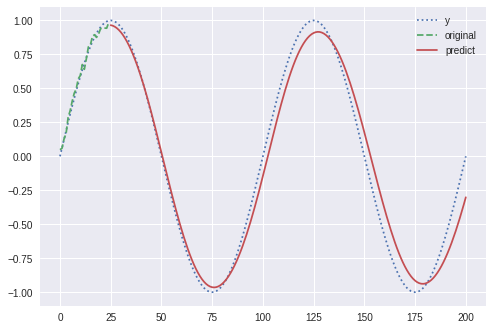

In [0]:
plt.plot(toy_problem(T=100, ampl=0), linestyle="dotted")
plt.plot(original, linestyle="dashed")
plt.plot(predicted)
plt.legend(["y","original","predict"])

## Tensorflow

In [0]:
import tensorflow as tf

In [0]:
input_data_column_cnt=1  # n-in
output_data_column_cnt=1   # n-out

seq_length=25 # maxlen
rnn_cell_hidden_dim=30  # n_hidden
forget_bias=1.0  # 망각편행 (기본값 1.0)
num_stacked_layers=1  # stacked LSTM layers 갯수

epoch_num=1000  # epoch
learning_rate=0.01

In [0]:
# 학습용/테스트용 데이터 생성
# 전체 70%를 학습용 데이터로 사용
train_size = int(len(X) * 0.7)
# 나머지(30%)를 테스트용 데이터로 사용
test_size = len(y) - train_size
 
# 데이터를 잘라 학습용 데이터 생성
trainX = np.array(X[0:train_size])
trainY = np.array(y[0:train_size])
 
# 데이터를 잘라 테스트용 데이터 생성
testX = np.array(X[train_size:len(X)])
testY = np.array(y[train_size:len(y)])

In [0]:
X=tf.placeholder(tf.float32,[None,seq_length,input_data_column_cnt])
Y=tf.placeholder(tf.float32,[None,1])

targets=tf.placeholder(tf.float32,[None,1])
predictions=tf.placeholder(tf.float32,[None,1])

In [0]:
num_hidden = 16
def lstm_cell() :
    cell = tf.contrib.rnn.BasicLSTMCell(num_hidden,forget_bias=forget_bias,
                                    state_is_tuple=True,activation=tf.nn.softsign)
    return cell

In [0]:
stackedRNNs=[lstm_cell() for _ in range(num_stacked_layers)]
multi_cells=tf.contrib.rnn.MultiRNNCell(stackedRNNs,state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


In [0]:
hypothesis, _states=tf.nn.dynamic_rnn(multi_cells,X,dtype=tf.float32)

In [0]:
hypothesis = tf.contrib.layers.fully_connected(hypothesis[:, -1], output_data_column_cnt, activation_fn=tf.identity)

In [0]:
loss=tf.reduce_sum(tf.square(hypothesis-Y))
optimizer=tf.train.AdamOptimizer(learning_rate)

In [0]:
train=optimizer.minimize(loss)

In [0]:
rmse=tf.sqrt(tf.reduce_mean(tf.squared_difference(targets,predictions)))

In [0]:
train_error_summary=[]
test_error_summary=[]
test_predict=''

In [0]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
for epoch in range(epoch_num):
    _, _loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
    if ((epoch+1) % 100 == 0) or (epoch == epoch_num-1): # 100번째마다 또는 마지막 epoch인 경우
        # 학습용데이터로 rmse오차를 구한다
        train_predict = sess.run(hypothesis, feed_dict={X: trainX})
        train_error = sess.run(rmse, feed_dict={targets: trainY, predictions: train_predict})
        train_error_summary.append(train_error)
 
        # 테스트용데이터로 rmse오차를 구한다
        test_predict = sess.run(hypothesis, feed_dict={X: testX})
        test_error = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
        test_error_summary.append(test_error)
        
        # 현재 오류를 출력한다
        print("epoch: {}, train_error(A): {}, test_error(B): {}, B-A: {}".format(epoch+1, train_error, test_error, test_error-train_error))


epoch: 100, train_error(A): 0.03345312550663948, test_error(B): 0.034954752773046494, B-A: 0.001501627266407013
epoch: 200, train_error(A): 0.032013412564992905, test_error(B): 0.03426719084382057, B-A: 0.0022537782788276672
epoch: 300, train_error(A): 0.031400203704833984, test_error(B): 0.03372332826256752, B-A: 0.0023231245577335358
epoch: 400, train_error(A): 0.03080906718969345, test_error(B): 0.03330106660723686, B-A: 0.0024919994175434113
epoch: 500, train_error(A): 0.030284935608506203, test_error(B): 0.033033065497875214, B-A: 0.002748129889369011
epoch: 600, train_error(A): 0.029857251793146133, test_error(B): 0.03290271386504173, B-A: 0.0030454620718955994
epoch: 700, train_error(A): 0.0294773168861866, test_error(B): 0.032860711216926575, B-A: 0.003383394330739975
epoch: 800, train_error(A): 0.029101036489009857, test_error(B): 0.03279676288366318, B-A: 0.0036957263946533203
epoch: 900, train_error(A): 0.0289460401982069, test_error(B): 0.03263968229293823, B-A: 0.003693642

In [0]:
epochs=1000
batch_size=10
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

n_batches = len(trainX) // batch_size
from sklearn.utils import shuffle

In [0]:
my_loss = []
for epoch in range(epochs):
    X_, Y_ = shuffle(trainX, trainY)
    
    for i in range(n_batches):
        start = i* batch_size
        end = start + batch_size
    
    sess.run(train, feed_dict={
        X: X_[start:end], 
        Y: Y_[start:end]
    })
    
    val_loss = loss.eval(session=sess, feed_dict={
        X: testX, 
        Y: testY
    })
    my_loss.append(val_loss)
    
    if epoch%50==0 :
        print("epoch:", epoch, "validation loss:", val_loss)
print("epoch:", epoch, "validation loss:", my_loss[-1])

epoch: 0 validation loss: 19.151684
epoch: 50 validation loss: 0.2529941
epoch: 100 validation loss: 0.0964679
epoch: 150 validation loss: 0.11071161
epoch: 200 validation loss: 0.08819667
epoch: 250 validation loss: 0.07511838
epoch: 300 validation loss: 0.07253744
epoch: 350 validation loss: 0.076529935
epoch: 400 validation loss: 0.074406825
epoch: 450 validation loss: 0.072189786
epoch: 500 validation loss: 0.08243407
epoch: 550 validation loss: 0.069672465
epoch: 600 validation loss: 0.076844506
epoch: 650 validation loss: 0.07448575
epoch: 700 validation loss: 0.095993795
epoch: 750 validation loss: 0.08598601
epoch: 800 validation loss: 0.08330682
epoch: 850 validation loss: 0.0845018
epoch: 900 validation loss: 0.08789969
epoch: 950 validation loss: 0.070543416
epoch: 999 validation loss: 0.069430366


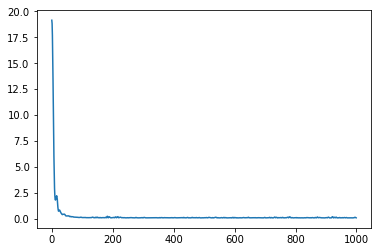

In [0]:
plt.plot(my_loss)

In [0]:
original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

In [0]:
for i in range(0,train_predict.shape[0]) :
    predicted.append(train_predict[i])
for i in range(0,test_predict.shape[0]) :
    predicted.append(test_predict[i])

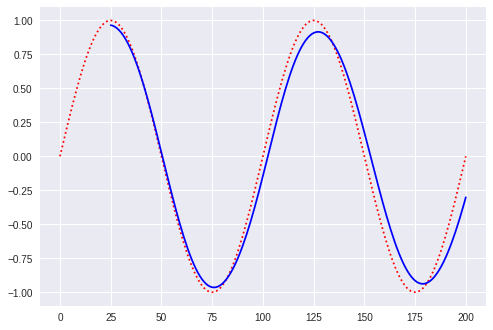

In [0]:
plt.plot(toy_problem(T=100, ampl=0),'r', linestyle="dotted")
plt.plot(predicted, 'b')